# Galaxies within 0.2 dex of Speagle's Relation

#### Cosmology: Planck2015
#### Simulation Name: TNG-50
#### Redshift:0 

In [1]:
import illustris_python as il
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
import tempfile
import h5py
from astropy.cosmology import Planck15 as cosmo
from scipy.optimize import curve_fit

In [2]:
def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    
    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string
    
    return r

In [3]:
sim_name = "TNG50-1"
snapshot_num = 99
api_key = '29fdb501f084ab3bde756d4827030bcb'
headers = {"api-key": api_key}

In [4]:
simulationHeader = get('http://www.tng-project.org/api/'+sim_name)
simulationHeader

{'name': 'TNG50-1',
 'description': 'Main high-resolution IllustrisTNG50 run including the full TNG physics model.',
 'name_alt': 'L35n2160TNG',
 'boxsize': 35000.0,
 'z_start': 127.0,
 'z_final': 0.0,
 'cosmology': 'Planck2015',
 'omega_0': 0.3089,
 'omega_L': 0.6911,
 'omega_B': 0.0486,
 'hubble': 0.6774,
 'physics_model': 'Fiducial TNG Model',
 'has_cooling': True,
 'has_starformation': True,
 'has_winds': True,
 'has_blackholes': True,
 'mass_gas': 5.73879e-06,
 'mass_dm': 3.07367708626464e-05,
 'softening_dm_comoving': 0.39,
 'softening_stars_comoving': 0.39,
 'softening_blackholes_comoving': 0.39,
 'softening_gas_comoving': 0.39,
 'softening_dm_max_phys': 0.195,
 'softening_stars_max_phys': 0.195,
 'softening_blackholes_max_phys': 0.39,
 'softening_gas_max_phys': 0.195,
 'softening_gas_factor': 2.5,
 'softening_gas_comoving_min': 0.05,
 'num_dm': 10077696000,
 'num_tr_mc': 10077696000,
 'num_tr_vel': 0,
 'longids': True,
 'is_uniform': True,
 'is_zoom': False,
 'is_subbox': False

# PREPARING THE DATA
The following data is available:<br>
1. Subhalo Mass
2. $R_{eff}$
3. Stellar Mass
4. Dark Matter Mass
5. Gaseous Mass
6. SFR
7. $V_{max}$
8. Velocity Dispersion

In [5]:
basePath = 'sims.TNG/TNG50-1/output'
full_data=il.groupcat.loadSubhalos(basePath,99,fields=['SubhaloMassType','SubhaloHalfmassRad','SubhaloHalfmassRadType','SubhaloFlag','SubhaloMass','SubhaloSFR','SubhaloVmax','SubhaloVelDisp'])
full_data

{'count': 5688113,
 'SubhaloMassType': array([[1.5599565e+03, 1.1360775e+04, 0.0000000e+00, 0.0000000e+00,
         3.6829300e+02, 5.7902855e-01],
        [5.6984951e-03, 1.4266774e+02, 0.0000000e+00, 0.0000000e+00,
         2.6731363e+01, 5.4223195e-02],
        [2.2737451e-01, 1.4377763e+02, 0.0000000e+00, 0.0000000e+00,
         1.3025371e+01, 2.9711133e-02],
        ...,
        [0.0000000e+00, 9.8357664e-04, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 9.8357664e-04, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 7.9915603e-04, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32),
 'SubhaloHalfmassRad': array([362.2303   ,  29.539518 ,  58.69923  , ...,   2.2308853,
          1.787874 ,   2.9835608], dtype=float32),
 'SubhaloHalfmassRadType': array([[383.19537  , 371.71152  ,   0.       ,   0.       ,  29.281168 ,
           0.       ],
        [  5.2835

Conversion of units from comoving to physical, $\frac{10^{10}}{h} M_{\odot}$ to $M_{\odot}$ etc

In [6]:
z=0
a=1/(1+z)
h=0.6774

ID=np.arange(0,len(full_data['SubhaloFlag']))
Subhalomass_gas=full_data['SubhaloMassType'][:,0]*1e10/h
Subhalomass_star=full_data['SubhaloMassType'][:,4]*1e10/h
Subhalomass_dm=full_data['SubhaloMassType'][:,1]*1e10/h
Subhalo_sreff=full_data['SubhaloHalfmassRadType'][:,4]*a/h
Subhalo_reff=full_data['SubhaloHalfmassRad']*a/h
Subhalo_sfr=full_data['SubhaloSFR']
Subhalo_Vmax=full_data['SubhaloVmax']
Subhalo_Sigma=full_data['SubhaloVelDisp']
Subhalo_mass=full_data['SubhaloMass']*1e10/h

Pick galaxies of cosmological origin only, remove ones with SFR and Mass<0

In [7]:
good_ones=np.where((full_data['SubhaloFlag']==True) &(Subhalomass_star > 0) & (Subhalo_sfr > 0))
fields=[ID,Subhalomass_gas,Subhalomass_star,Subhalomass_dm,Subhalo_reff,Subhalo_sreff,Subhalo_sfr,Subhalo_Vmax,Subhalo_Sigma,Subhalo_mass]

newfields=[field[good_ones] for field in fields]
ID,Subhalomass_gas,Subhalomass_star,Subhalomass_dm,Subhalo_reff,Subhalo_sreff,Subhalo_sfr,Subhalo_Vmax,Subhalo_Sigma,Subhalo_mass=newfields

In [8]:
log_ms=np.log10(Subhalomass_star)
log_sfr=np.log10(Subhalo_sfr)

# Speagle's Relation
log SFR(M∗, t) = (0.84 ± 0.02 − 0.026 ± 0.003 × t) log M∗−(6.51 ± 0.24 − 0.11 ± 0.03 × t)

In [9]:
t=cosmo.age(0).value
slope=0.84-0.026*t
intercept=6.51-0.11*t
print(slope,intercept)

def speagle(logmass):
    return slope*(logmass)-intercept

0.4812619866806939 4.992262251341398


Remove outliers beyond 0.5 dex

In [10]:
good_ones=np.where((abs(speagle(log_ms)-log_sfr)<0.5))
fields=[ID,Subhalomass_gas,Subhalomass_star,Subhalomass_dm,Subhalo_reff,Subhalo_sreff,Subhalo_sfr,Subhalo_Vmax,Subhalo_Sigma,Subhalo_mass]

newfields=[field[good_ones] for field in fields]
ID,Subhalomass_gas,Subhalomass_star,Subhalomass_dm,Subhalo_reff,Subhalo_sreff,Subhalo_sfr,Subhalo_Vmax,Subhalo_Sigma,Subhalo_mass=newfields

In [11]:
log_ms=np.log10(Subhalomass_star)
log_sfr=np.log10(Subhalo_sfr)

In [12]:
print(log_ms.min(),log_ms.max())

5.0234647 12.21872


## Binning the Data

In [13]:
# Mass bins

mass_bins=np.linspace(log_ms.min(),log_ms.max(),15,endpoint=True)
bin_indices=np.digitize(log_ms, mass_bins, right=False)
binned_data={bin_start:[] for bin_start in mass_bins[0:-1]}

for i, bin_start in enumerate(mass_bins[0:-1]):
    mask=bin_indices==i+1
    binned_data[bin_start]=list(zip(log_ms[mask],log_sfr[mask]))

In [14]:
logms_to_plot=[(mass_bins[i]+mass_bins[i+1])/2 for i in range(len(mass_bins)-1)]
logsfr_to_plot = [np.median([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]

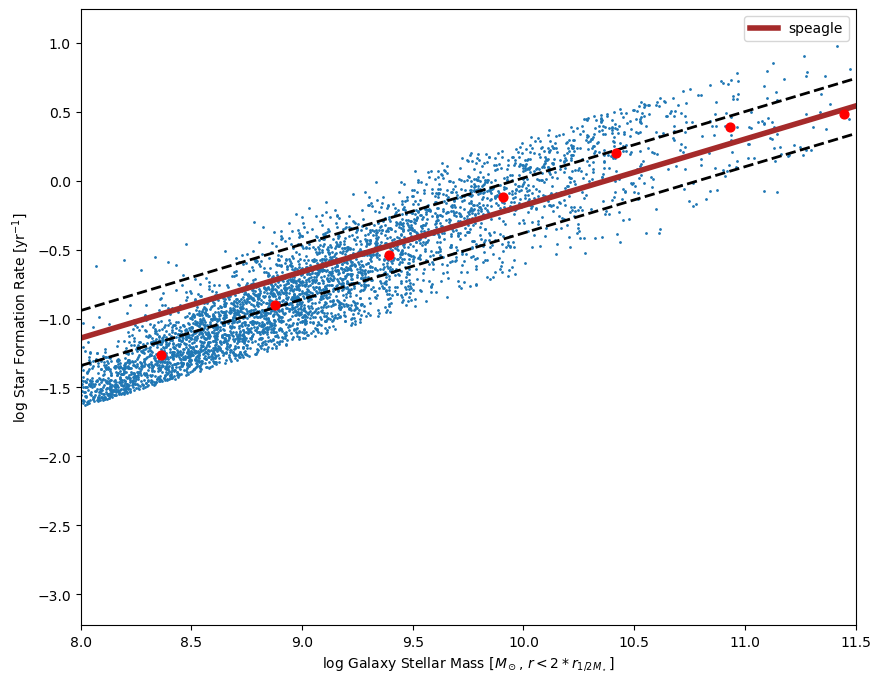

In [15]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111)
ax.plot(log_ms,log_sfr,'.',markersize=2)
x=np.linspace(8,11.5,len(log_ms))
speagle_values=(slope)*x - (intercept)

speagle,=ax.plot(x,speagle_values,label='speagle',linewidth=4,color='brown')
ax.plot(x,speagle_values+0.2,'--',color='black',linewidth=2)
ax.plot(x,speagle_values-0.2,'--',color='black',linewidth=2)
ax.scatter(logms_to_plot,logsfr_to_plot,color='red',s=40,zorder=5)

ax.set_xlim(8,11.5)
ax.set_xlabel('log Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}$]')
ax.set_ylabel('log Star Formation Rate [yr$^{-1}$]')
ax.legend()
plt.show()

## Attempting to Match Simulation Data with Observations

In [17]:
def line(x,m,c):
    return m*x+c

popt,pcov=curve_fit(line,logms_to_plot,logsfr_to_plot)

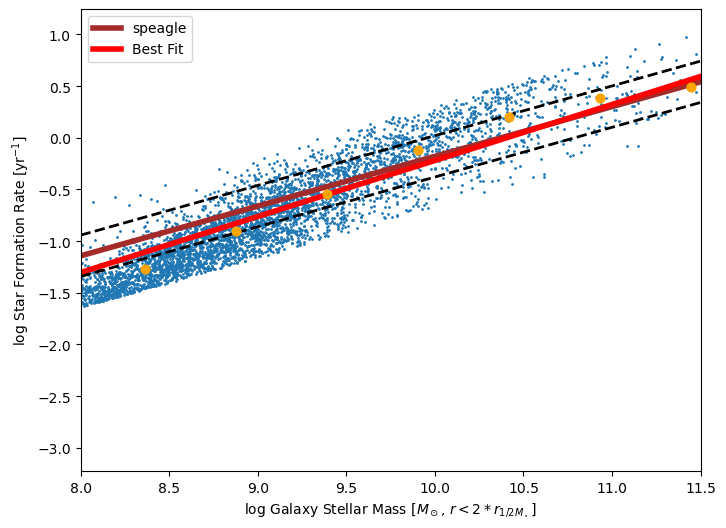

In [18]:
#Attempting to match data with Speagle's fit
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.plot(log_ms,log_sfr,'.',markersize=2)
x=np.linspace(8,11.5,len(log_ms))
speagle_values=(slope)*x - (intercept)

speagle,=ax.plot(x,speagle_values,label='speagle',linewidth=4,color='brown')
bestfit,=ax.plot(x,line(x,popt[0],popt[1]),label='Best Fit',linewidth=4,color='red')
ax.plot(x,speagle_values+0.2,'--',color='black',linewidth=2)
ax.plot(x,speagle_values-0.2,'--',color='black',linewidth=2)
ax.scatter(logms_to_plot,logsfr_to_plot,color='orange',s=40,zorder=5)

ax.set_xlim(8,11.5)
ax.set_xlabel('log Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}$]')
ax.set_ylabel('log Star Formation Rate [yr$^{-1}$]')
ax.legend()
plt.show()

In [19]:
good_ones=np.where(Subhalo_sreff > 0)
fields=[ID,Subhalomass_gas,Subhalomass_star,Subhalomass_dm,Subhalo_reff,Subhalo_sreff,Subhalo_sfr,Subhalo_Vmax,Subhalo_Sigma,Subhalo_mass]

newfields=[field[good_ones] for field in fields]
ID,Subhalomass_gas,Subhalomass_star,Subhalomass_dm,Subhalo_reff,Subhalo_sreff,Subhalo_sfr,Subhalo_Vmax,Subhalo_Sigma,Subhalo_mass=newfields

In [20]:
log_ms=np.log10(Subhalomass_star)
log_sreff=np.log10(Subhalo_sreff)

In [21]:
good_ones=np.where((log_ms > 8) & (log_ms <11.5))
fields=[ID,Subhalomass_gas,Subhalomass_star,Subhalomass_dm,Subhalo_reff,Subhalo_sreff,Subhalo_sfr,Subhalo_Vmax,Subhalo_Sigma,Subhalo_mass]

newfields=[field[good_ones] for field in fields]
ID,Subhalomass_gas,Subhalomass_star,Subhalomass_dm,Subhalo_reff,Subhalo_sreff,Subhalo_sfr,Subhalo_Vmax,Subhalo_Sigma,Subhalo_mass=newfields

In [22]:
log_ms=np.log10(Subhalomass_star)
log_sreff=np.log10(Subhalo_sreff)

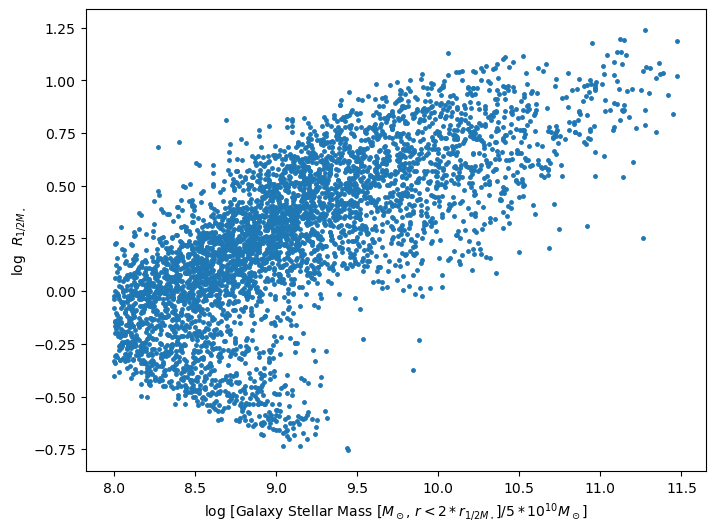

In [23]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.plot(log_ms,log_sreff,'.',markersize=5)

ax.set_xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}]/5*10^{10}M_\odot$]')
ax.set_ylabel('log  $R_{1/2 M_\star}$')
plt.show()

## EXTRACTING MASS-SIZE RELATION @ z=0
Paper: Lapi et al 2018 <br>
Points obtained by digitizing Fig-6 <br>
x, y <br>
9.00507614213198, 0.4129205921938089<br>
9.302030456852792, 0.4979811574697174<br>
9.598984771573605, 0.570121130551817<br>
9.898477157360405, 0.619650067294751<br>
10.200507614213198, 0.682099596231494<br>
10.50253807106599, 0.7574697173620457<br>
10.802030456852792, 0.8242261103633917<br>
11.101522842639593, 0.9189771197846568<br>
11.403553299492385, 1.0201884253028264<br>

In [24]:
x=9.00507614213198, 9.302030456852792, 9.598984771573605, 9.898477157360405, 10.200507614213198, 10.50253807106599, 10.802030456852792, 11.101522842639593, 11.403553299492385 
y=0.4129205921938089,0.4979811574697174,0.570121130551817,0.619650067294751,0.682099596231494,0.7574697173620457,0.8242261103633917,0.9189771197846568,1.0201884253028264

In [25]:
x=np.array(x)
y=np.array(y)
z=np.poly1d(np.polyfit(x,y,4))
z

poly1d([-1.36758357e-02,  5.90248047e-01, -9.48322256e+00,  6.74878510e+01,
       -1.79402138e+02])

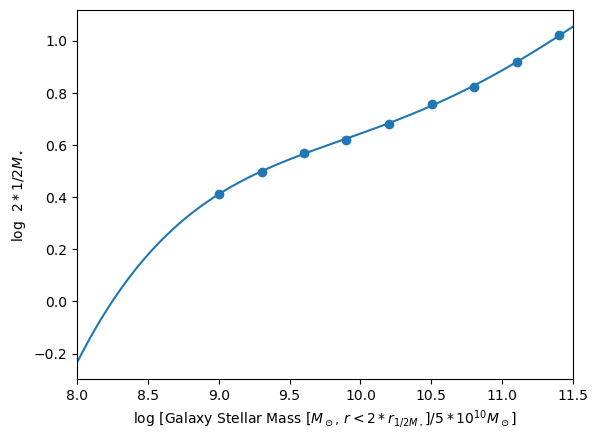

In [26]:
x_values=np.linspace(8,11.5,100)
plt.scatter(x,y)
plt.plot(x_values,z(x_values))
plt.xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}]/5*10^{10}M_\odot$]')
plt.ylabel('log  $2*{1/2 M_\star}$')
#plt.ylim(0.4,1.2)
plt.xlim(8,11.5)
plt.show()

## MATCHING

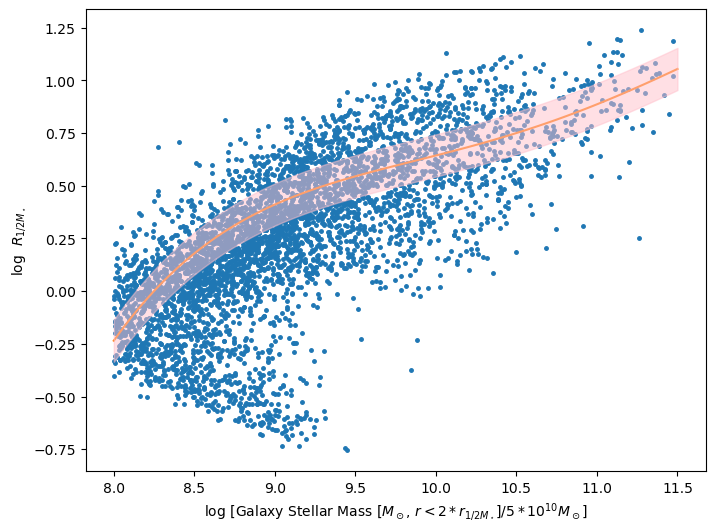

In [27]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.plot(log_ms,log_sreff,'.',markersize=5)
ax.plot(x_values,z(x_values))
ax.fill_between(x_values,z(x_values)+0.1,z(x_values)-0.1,color='pink',alpha=0.5,zorder=2)

ax.set_xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}]/5*10^{10}M_\odot$]')
ax.set_ylabel('log  $R_{1/2 M_\star}$')
plt.show()

Further clean the data to exclude that beyond 0.2 dex

In [28]:
good_ones=np.where(abs(z(log_ms)-log_sreff)<=0.2)
fields=[ID,Subhalomass_gas,Subhalomass_star,Subhalomass_dm,Subhalo_reff,Subhalo_sreff,Subhalo_sfr,Subhalo_Vmax,Subhalo_Sigma,Subhalo_mass]

newfields=[field[good_ones] for field in fields]
ID,Subhalomass_gas,Subhalomass_star,Subhalomass_dm,Subhalo_reff,Subhalo_sreff,Subhalo_sfr,Subhalo_Vmax,Subhalo_Sigma,Subhalo_mass=newfields

In [29]:
log_ms=np.log10(Subhalomass_star)
log_sreff=np.log10(Subhalo_sreff)

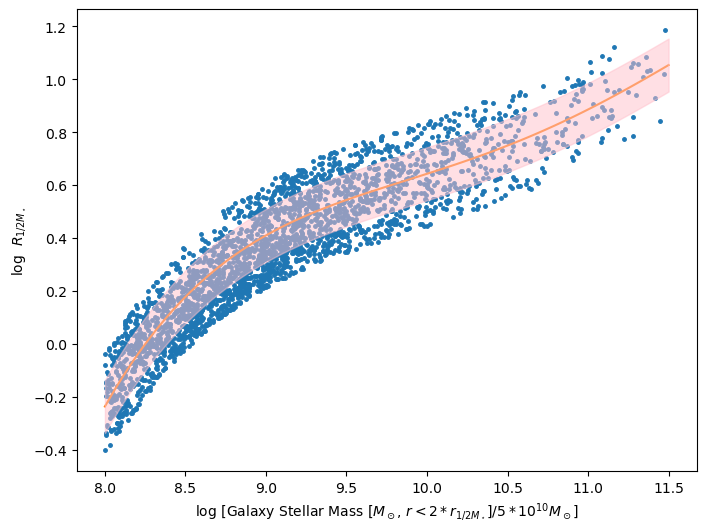

In [30]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.plot(log_ms,log_sreff,'.',markersize=5)
ax.plot(x_values,z(x_values))
ax.fill_between(x_values,z(x_values)+0.1,z(x_values)-0.1,color='pink',alpha=0.5,zorder=2)

ax.set_xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}]/5*10^{10}M_\odot$]')
ax.set_ylabel('log  $R_{1/2 M_\star}$')
plt.show()

## Binning the Data

In [34]:
# Mass bins

mass_bins=np.linspace(log_ms.min(),log_ms.max(),50,endpoint=True)
bin_indices=np.digitize(log_ms, mass_bins, right=False)
binned_data={bin_start:[] for bin_start in mass_bins[0:-1]}

for i, bin_start in enumerate(mass_bins[0:-1]):
    mask=bin_indices==i+1
    binned_data[bin_start]=list(zip(log_ms[mask],log_sreff[mask]))

In [35]:
logms_to_plot=[(mass_bins[i]+mass_bins[i+1])/2 for i in range(len(mass_bins)-1)]
logsreff_to_plot = [np.mean([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]

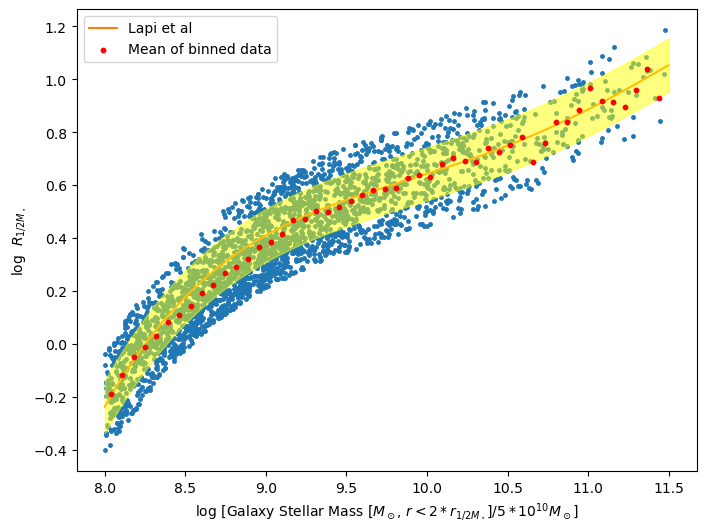

In [36]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.plot(log_ms,log_sreff,'.',markersize=5)
ax.plot(x_values,z(x_values),label='Lapi et al')
ax.scatter(logms_to_plot,logsreff_to_plot,color='red',s=10,zorder=3,label='Mean of binned data')
ax.fill_between(x_values,z(x_values)+0.1,z(x_values)-0.1,color='yellow',alpha=0.5,zorder=2)

ax.set_xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}]/5*10^{10}M_\odot$]')
ax.set_ylabel('log  $R_{1/2 M_\star}$')
ax.legend()
plt.show()

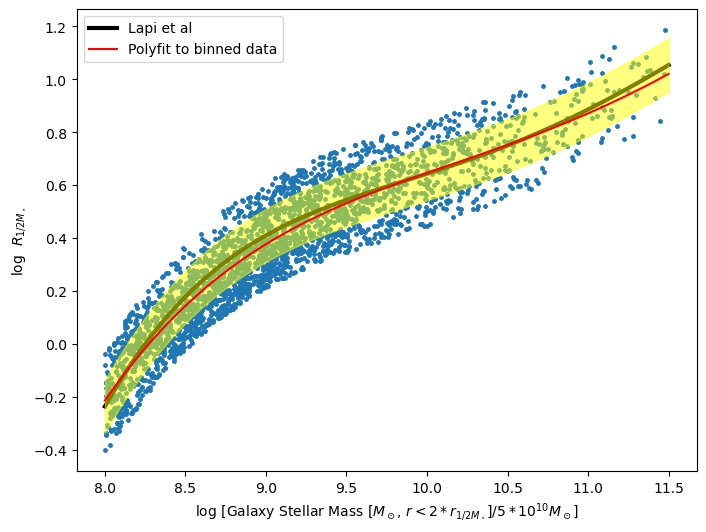

In [38]:
poly_bins=np.poly1d(np.polyfit(logms_to_plot,logsreff_to_plot,4))

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.plot(log_ms,log_sreff,'.',markersize=5)
ax.plot(x_values,z(x_values),color='black',label='Lapi et al',linewidth=3)
ax.plot(x_values,poly_bins(x_values),color='red',zorder=3,label='Polyfit to binned data')
ax.fill_between(x_values,z(x_values)+0.1,z(x_values)-0.1,color='yellow',alpha=0.5,zorder=2)

ax.set_xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}]/5*10^{10}M_\odot$]')
ax.set_ylabel('log  $R_{1/2 M_\star}$')
ax.legend()
plt.show()

In [39]:
rs=np.zeros((len(ID)))

In [40]:
df=pd.DataFrame({'$M_{gas},M_{\odot}$':Subhalomass_gas,'$M_{stellar},M_{\odot}$':Subhalomass_star,'$M_{DM},M_{\odot}$':Subhalomass_dm,'$R_{eff}$(kpc)':Subhalo_reff,'SFR($M_{\odot}/yr$)':Subhalo_sfr,'$V_{max}$(km/s)':Subhalo_Vmax,'$\sigma_v$(km/s)':Subhalo_Sigma,
                'M':Subhalo_mass,'z':rs})
df

,"$M_{gas},M_{\odot}$","$M_{stellar},M_{\odot}$","$M_{DM},M_{\odot}$",$R_{eff}$(kpc),SFR($M_{\odot}/yr$),$V_{max}$(km/s),$\sigma_v$(km/s),M,z
0,9.942768e+09,3.748761e+10,2.293002e+11,25.054882,1.058097,164.306885,83.149658,2.767828e+11,0.0
1,8.177316e+09,8.527347e+09,2.145131e+11,40.584583,0.599846,129.189194,63.097786,2.312468e+11,0.0
2,3.438601e+09,1.832122e+10,1.334445e+11,15.716292,0.831690,155.352066,85.644264,1.552636e+11,0.0
3,5.167198e+09,3.898073e+09,8.245341e+10,22.837128,0.409650,95.565742,52.729660,9.152934e+10,0.0
4,5.595890e+09,3.734586e+09,6.362112e+10,16.891312,1.056872,100.277756,56.704617,7.296107e+10,0.0
...,...,...,...,...,...,...,...,...,...
2499,9.689527e+08,1.187615e+08,1.678498e+10,14.385835,0.035828,52.549076,28.845589,1.787269e+10,0.0
2500,9.563500e+08,1.617670e+08,2.147581e+10,17.766489,0.033303,55.391529,28.973156,2.259393e+10,0.0
2501,1.617733e+09,1.087675e+08,1.805275e+10,18.209703,0.042844,51.211151,27.163065,1.977925e+10,0.0
2502,1.175052e+09,1.862059e+08,2.049027e+10,15.039311,0.041461,58.556171,30.749409,2.185153e+10,0.0


In [41]:
df.to_csv('z=0.csv')